In [1]:
import glob
import os
import shutil

import numpy as np
import pylab as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
from pipeline.python.utils import convert_range
import scipy.stats as spstats


from pipeline.python.utils import natural_keys, label_figure
from pipeline.python import utils as putils

import traceback
from pipeline.python.retinotopy import utils as ret_utils
from pipeline.python.rois import utils as roi_utils
from pipeline.python.paradigm import utils as par_utils
from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf
import sklearn.metrics as skmetrics
from pipeline.python.coregistration import align_fov as coreg

import json
import tifffile as tf
from scipy import ndimage


import cv2
from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.colors as mcolors
import cPickle as pkl
import h5py

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/do_retinotopy_analysis.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    a

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/rois/utils.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/hom

In [2]:
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.classifications import rf_utils as rfutils

from sklearn.linear_model import LinearRegression, Ridge, Lasso
#from sklearn.model_selection import train_test_split
import scipy.stats as spstats
import sklearn.metrics as skmetrics #import mean_squared_error

import seaborn as sns

In [3]:
import imutils
from scipy.ndimage.morphology import binary_dilation


In [4]:
%matplotlib inline

In [5]:
def dilate_mask_centers(maskcenters, kernel_size=9):
    '''Calculate center of soma, then dilate to create masks for smoothed  neuropil
    '''
    kernel_radius = (kernel_size - 1) // 2
    x, y = np.ogrid[-kernel_radius:kernel_radius+1, -kernel_radius:kernel_radius+1]
    dist = (x**2 + y**2)**0.5 # shape (kernel_size, kernel_size)

    # let's create three kernels for the sake of example
    radii = np.array([kernel_size/3., kernel_size/2.5, kernel_size/2.])[...,None,None] # shape (num_radii, 1, 1)
    # using ... allows compatibility with arbitrarily-shaped radius arrays

    kernel = (1 - (dist - radii).clip(0,1)).sum(axis=0)# shape (num_radii, kernel_size, kernel_size)

    dilated_masks = np.zeros(maskcenters.shape, dtype=maskcenters.dtype)
    for roi in range(maskcenters.shape[0]):
        img = maskcenters[roi, :, :].copy()
        x, y = np.where(img>0)
        centroid = (sum(x) / len(x), sum(y) / len(x))
        #print(centroid)
        np_tmp = np.zeros(img.shape, dtype=bool)
        np_tmp[centroid] = True
        dilation = binary_dilation(np_tmp, structure=kernel )
        dilated_masks[roi, : :] = dilation
    return dilated_masks

def mask_rois(masks, value_array, mask_thr=0.1, return_array=False):
    '''
    value_array: indices should be RIDs -- these ixs are used to index into masks.
    '''
    nrois, d1, d2 = masks.shape
    dims = (d1, d2)

    if return_array:
        value_mask = np.ones(masks.shape)*np.nan #-100
        for rid in value_array.index.tolist():
            value_mask[rid, masks[rid,:,:]>=mask_thr] = value_array[rid]

    else:
        value_mask =  np.ones(dims)*-100
        for rid in value_array.index.tolist():
            value_mask[masks[rid,:,:]>=mask_thr] = value_array[rid]

    return value_mask



def mask_with_overlaps_averaged(dilated_masks, value_array, mask_thr=0.1,
                               is_circular=False, vmin=-np.pi, vmax=np.pi):
    '''
    value_array: indices should be RIDs -- these ixs are used to index into masks.
    '''
    
    nrois, d1, d2 = dilated_masks.shape
    
    # Get non-averaged array, shape=(d1, d2)
    tmpmask = mask_rois(dilated_masks, value_array, mask_thr=mask_thr, return_array=False)
    #print("no array:", tmpmask.shape, value_array.shape)
    
    # Get full array to average across overlapping pixels, shape=(nrois, d1, d2)?
    tmpmask_full = mask_rois(dilated_masks, value_array, mask_thr=mask_thr, return_array=True)
    #print("arr:", tmpmask_full.shape, value_array.shape)
    tmpmask_r = np.reshape(tmpmask_full, (nrois_total, d1*d2))
    
    # Replace overlapping pixels with average value
    avg_mask = tmpmask.copy().ravel()
    multi_ixs = [i for i in range(tmpmask_r.shape[-1]) if len(np.where(tmpmask_r[:, i])[0]) > 1]
    for ix in multi_ixs:
        if is_circular:
            avg_mask[ix] = spstats.circmean([v for v in tmpmask_r[:, ix] if not np.isnan(v)], low=vmin, high=vmax)
        else:
            avg_mask[ix] = np.nanmean([v for v in tmpmask_r[:, ix] if not np.isnan(v)])#, low=vmin, high=vmax)

    avg_mask = np.reshape(avg_mask, (d1, d2))

    return avg_mask

In [6]:
def get_phase_masks(masks, phases, average_overlap=True, roi_list=None, return_absolute=False,
                    use_cont=True, mask_thr=0.01):
    # Convert phase to continuous:
    phases_cont = -1 * phases
    phases_cont = phases_cont % (2*np.pi)
    
    # Only include specified rois:
    if roi_list is None:
        roi_list = phases.index.tolist()
        
    # Get absolute maps:
    if use_cont:
        elev = (phases_cont['bottom'] - phases_cont['top']) / 2.
        azim = (phases_cont['left'] - phases_cont['right']) / 2.
        vmin = -np.pi
        vmax = np.pi
    else:
        # Get absolute maps:
        elev = (phases['bottom'] - phases['top']) / 2.
        azim = (phases['left'] - phases['right']) / 2.
        
        # Convert to continueous:
        elev_c = -1 * elev
        elev_c = elev_c % (2*np.pi)
        azim_c = -1 * azim
        azim_c = azim_c % (2*np.pi)

        vmin = 0
        vmax = 2*np.pi

        azim = copy.copy(azim_c)
        elev = copy.copy(elev_c)
        
    if average_overlap:
        azim_phase = mask_with_overlaps_averaged(masks, azim[roi_list], mask_thr=mask_thr)
        elev_phase = mask_with_overlaps_averaged(masks, elev[roi_list], mask_thr=mask_thr)
    else:
        azim_phase = mask_rois(masks, azim[roi_list], mask_thr=mask_thr)
        elev_phase = mask_rois(masks, elev[roi_list], mask_thr=mask_thr)   
    
    
    if return_absolute:
        return azim_phase, elev_phase, azim, elev
    else:
        return azim_phase, elev_phase



In [7]:
from scipy.interpolate import SmoothBivariateSpline

def fill_and_smooth_nans(img):

    y, x = np.meshgrid(np.arange(0, img.shape[1]), np.arange(0, img.shape[0]))
    x = x.astype(float)
    y = y.astype(float)
    z = img.copy()
    
    xx = x.copy()
    yy = y.copy()
    xx[np.isnan(z)] = np.nan
    yy[np.isnan(z)] = np.nan

    xx=xx.ravel()
    xx=(xx[~np.isnan(xx)])
    yy=yy.ravel()
    yy=(yy[~np.isnan(yy)])
    zz=z.ravel()
    zz=(zz[~np.isnan(zz)])

#     xnew = np.arange(xx.min(), xx.max()+1) #np.arange(9,11.5, 0.01)
#     ynew = np.arange(yy.min(), yy.max()+1) #np.arange(10.5,15, 0.01)

#     f = SmoothBivariateSpline(xx,yy,zz,kx=1,ky=1)
#     znew=np.transpose(f(xnew, ynew)).T

    xnew = np.arange(x.ravel().min(), x.ravel().max()+1) #np.arange(9,11.5, 0.01)
    ynew = np.arange(y.ravel().min(), y.ravel().max()+1) #np.arange(10.5,15, 0.01)
    
    #print(xnew.min(), xnew.max())
    
    f = SmoothBivariateSpline(xx,yy,zz,kx=1,ky=1)
    znew=f(xnew, ynew) #).T
    
    znew[np.isnan(z)] = np.nan
    
    #print(z.shape, znew.shape)
    return znew #.T #a


In [8]:
def calculate_gradients(img):
    # Get gradient
    gdy, gdx = np.gradient(img)
    
    # 3) Calculate the magnitude
    gradmag = np.sqrt(gdx**2 + gdy**2)

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    #scale_factor = np.max(gradmag)/255
    #gradmag = (gradmag/scale_factor).astype(np.uint8)

    # 3) Take the absolute value of the x and y gradients
    abs_gdx = np.absolute(gdx)
    abs_gdy = np.absolute(gdy)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    abs_gd = np.arctan2(gdy, gdx) # np.arctan2(abs_gdy, abs_gdx) # [-pi, pi]

    # Get mean direction
    #mean_dir = np.rad2deg(np.arctan2(gdy.mean(), gdx.mean())) # TODO why this diff
#     mean_dir = np.rad2deg(spstats.circmean([np.arctan2(gy, gx) for gy, gx in zip(gdy.ravel(), gdx.ravel())],
#                          low=-np.pi, high=np.pi)) # TODO why this diff
    mean_dir = np.rad2deg(spstats.circmean([np.arctan2(gy, gx) for gy, gx in zip(gdy.ravel(), gdx.ravel())\
                                               if ((not np.isnan(gy)) and (not np.isnan(gx)))],
                         low=-np.pi, high=np.pi)) # TODO why this diff

    # Get unit vector
    avg_gradient = spstats.circmean(abs_gd[~np.isnan(abs_gd)], low=-np.pi, high=np.pi) #.mean()
    dirvec = (np.cos(avg_gradient), np.sin(avg_gradient))
    vhat = dirvec / np.linalg.norm(dirvec)

    grad_ = {'image': img,
             'magnitude': gradmag,
             'gradient_x': gdx,
             'gradient_y': gdy,
             'direction': abs_gd,
             'mean_deg': mean_dir, # DEG
             'mean_direction': avg_gradient, # RADIANS
             'vhat': vhat}
    
    return grad_


def plot_gradients(grad_, ax=None, draw_interval=3, scale=1, width=0.005, toy=False, headwidth=5):
    '''
    scale:  # of dat units per arrow length unit (smaller=longer arrow)
    scale_units 
    weight = width of plot
    angles='xy' (i.e., arrows point from (x,y) to (x+u, y+v))
    Arrows should point TOWARD larger numbers
    '''
    if ax is None:
        fig, ax = pl.subplots()
        
    gradimg = grad_['image']
    mean_dir = grad_['mean_deg']
    gdx = grad_['gradient_x']
    gdy = grad_['gradient_y']
    
    # Set limits and number of points in grid
    y, x = np.mgrid[0:gradimg.shape[0], 0:gradimg.shape[1]]

    # Every 3rd point in each direction.
    skip = (slice(None, None, draw_interval), slice(None, None, draw_interval))
    
    # plot
    ax.quiver(x[skip], y[skip], gdx[skip], gdy[skip], color='k',
              scale=scale, width=width,
              scale_units='xy', angles='xy', pivot='mid', units='width',
              headwidth=headwidth)
    
    gdir_ = grad_['direction'].copy()
    gmean = spstats.circmean(gdir_[~np.isnan(gdir_)], low=-np.pi, high=np.pi)
    
    avg_dir_grad = np.rad2deg(gmean) #np.nanmean(grad_['direction']))
    
    ax.set(aspect=1, title="Mean: %.2f\n(dir: %.2f)" % (mean_dir, avg_dir_grad))

    return ax

In [9]:

def get_retino_metadata(experiment='retino', animalids=None,
                        roi_type='manual2D_circle', traceid=None,
                        rootdir='/n/coxfs01/2p-data', 
                        aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas'):

    sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
   
    meta_list=[]
    for (animalid, session, fov), g in sdata.groupby(['animalid', 'session', 'fov']):
        if animalids is not None:
            if animalid not in animalids:
                continue
        exp_list = [e for e in g['experiment'].values if experiment in e] 
        if len(exp_list)==0:
            print('skipping, no retino (%s, %s, %s)' % (animalid, session, fov)) 
        retino_dirs = glob.glob(os.path.join(rootdir, animalid, session, fov, '%s*' % experiment,
                                'retino_analysis'))
        # get analysis ids for non-pixel
        for retino_dir in retino_dirs:
            retino_run = os.path.split(os.path.split(retino_dir)[0])[-1]
            if traceid is None:
                rid_fpath = glob.glob(os.path.join(retino_dir, 'analysisids_*.json'))[0]
                with open(rid_fpath, 'r') as f:
                    retids = json.load(f)
                traceids = [r for r, res in retids.items() if res['PARAMS']['roi_type']==roi_type] 
                for traceid in traceids: 
                    meta_list.append(tuple([animalid, session, fov, retino_run, traceid]))
            else:
                meta_list.append(tuple([animalid, session, fov, retino_run, traceid]))

    return meta_list



## Some aggregate plotting stuff

In [10]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

dpi = 150

# Select dataset

In [11]:
rootdir = '/n/coxfs01/2p-data'
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

traceid = 'traces001'


# Set output dirs

In [12]:
aggr_retino_dir = os.path.join(aggr_dir, 'retinotopy') #, 'figures', 'caiman-examples')
if not os.path.exists(aggr_retino_dir):
    os.makedirs(aggr_retino_dir)
aggr_retino_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy'

# Example FOV -------------------------------------------------------------------------------

In [13]:
animalid = 'JC085' #'JC085'
session = '20190622' #'20190626'
fov = 'FOV1_zoom2p0x'
retinorun = 'retino_run1'


# Load data

In [14]:
# Load data metainfo
run_dir = os.path.join(rootdir, animalid, session, fov, retinorun)
RETID = ret_utils.load_retinoanalysis(run_dir, traceid)
analysis_dir = RETID['DST']
retinoid = RETID['analysis_id']
print("Loaded: %s, %s (%s))" % (retinorun, retinoid, run_dir))
data_id = '_'.join([animalid, session, fov, retinorun, retinoid])
print("data ID: %s" % data_id)

# Load MW info and SI info
mwinfo = ret_utils.load_mw_info(animalid, session, fov, retinorun)
scaninfo = ret_utils.get_protocol_info(animalid, session, fov, run=retinorun) # load_si(run_dir)
trials_by_cond = scaninfo['trials']

# Set current animal's retino output dir
curr_dst_dir = os.path.join(run_dir, 'retino_analsysis', 'retino-structure')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print("Saving output to:\n %s" % curr_dst_dir)

Loaded: retino_run1, analysis002 (/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1))
data ID: JC085_20190622_FOV1_zoom2p0x_retino_run1_analysis002
Saving output to:
 /n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1/retino_analsysis/retino-structure


# Select colormap

In [16]:
reload(ret_utils)

<module 'pipeline.python.retinotopy.utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/utils.py'>

In [17]:
# Load colormap
cmap_name = 'nic_Edge'
zero_center = True
screen, cmap_phase = ret_utils.get_retino_legends(cmap_name=cmap_name, zero_center=zero_center, 
                                                  return_cmap=True, dst_dir=None)

# Get mask info

In [18]:
# Get ROIID and projection image
masks_soma, masks_np, zimg = ret_utils.load_soma_and_np_masks(RETID)
roiid = RETID['PARAMS']['roi_id']
ds_factor = int(RETID['PARAMS']['downsample_factor'])
nrois_total, d1, d2 = masks_soma.shape

# fig, ax = pl.subplots()
# roi_utils.plot_neuropil_masks(masks_soma, masks_np, zimg, ax=ax)
# ax.set_title('soma + neuropil masks')
# label_figure(fig, data_id)
# pl.savefig(os.path.join(curr_dst_dir, 'soma-v-neuropil-masks.png'))

... FOV size: (256, 256) (downsample factor=2)


# Dilate soma masks
From Liang et al., 2018, Cell.
1. Assign center of neuropil ring w/ preferred retino location.
2. From Neurpil ring center, dilate by a disk of 10um radius (20um diam)
3. Average overlapping disks
4. Spatially smooth w/ isotropic 2D Guassian filter (std=2um) for final pixe-wise estimates 

Nots: measured pixel size: (2.3, 1.9)
Want to dilate by ~9.52380952381


In [19]:
desired_radius_um = 10.0 #20.0
pixel_size = putils.get_pixel_size()
um_per_pixel = np.mean(pixel_size) / ds_factor # divide by DS factor (pixels are half if ds=2)
pixels2dilate = desired_radius_um/um_per_pixel
print("Measured pixel size: %s (~%.2fum/pix).\nPixel size with ds_factor %.2f = %i" % (str(pixel_size), um_per_pixel, ds_factor, pixels2dilate))



Measured pixel size: (2.3, 1.9) (~1.05um/pix).
Pixel size with ds_factor 2.00 = 9


In [20]:
check_masks = False

# Set kernel params
kernel_size = np.ceil(pixels2dilate) #+2 #21
kernel_radius = (kernel_size - 1) // 2
x, y = np.ogrid[-kernel_radius:kernel_radius+1, -kernel_radius:kernel_radius+1]
dist = (x**2 + y**2)**0.5 # shape (kernel_size, kernel_size)

# Create three kernels for the sake of example
radii = np.array([kernel_size/3., kernel_size/2.5, kernel_size/2.])[...,None,None] # shape (num_radii, 1, 1)
kernel = (1 - (dist - radii).clip(0,1)).sum(axis=0)# shape (num_radii, kernel_size, kernel_size)
kernel_diam_um = (kernel.shape[0]*um_per_pixel)
print("Kernel (%s), Dilation diameter (um): %.2f" % (str(kernel.shape), kernel_diam_um))

## Dilate all masks with kernel
dilated_masks = dilate_mask_centers(masks_soma.astype(float), kernel_size=kernel_size)

if check_masks:
    fig, axn = pl.subplots(1, 2, figsize=(3,6))
    axn[0].imshow(kernel)

    rid = 33
    axn[1].imshow(dilated_masks[rid, :, :])
    axn[1].set_title("Kernel size: %.2f\n(final diam: %.2f um)" % (kernel_size, kernel_diam_um))
    x, y = np.where(dilated_masks[rid, :, :]>0)
    print "X/Y-min/max:", x.max()-x.min(), y.max()-y.min()


Kernel ((9, 9)), Dilation diameter (um): 9.45


# Rescale FOV image

((256, 256), (1177, 972))


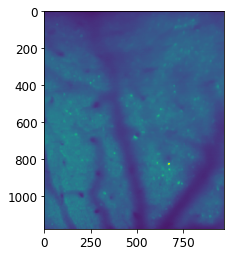

In [21]:
pixel_size = putils.get_pixel_size()
pixel_size = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)

zimg_r = coreg.transform_2p_fov(zimg, pixel_size)
print(zimg.shape, zimg_r.shape)

pl.figure()
pl.imshow(zimg_r)

# Process raw traces

In [22]:
#### Load raw and process traces -- returns average trace for condition
temporal_ds = float(RETID['PARAMS']['average_frames'])

#### Load raw and process traces -- returns average trace for condition
retino_dpath = os.path.join(analysis_dir, 'traces', 'extracted_traces.h5')
temporal_ds = float(RETID['PARAMS']['average_frames'])
np_traces = ret_utils.load_traces(animalid, session, fov, run=retinorun,
                                  analysisid=retinoid, trace_type='neuropil')
soma_traces = ret_utils.load_traces(animalid, session, fov, run=retinorun,
                                  analysisid=retinoid, trace_type='raw')

... loading traces (neuropil)
... loading traces (raw)


# Do FFT analysis

Mag ratio: 0.01
[soma] 54 out of 389 cells pass mag-ratio thr (thr>=0.010, all)
[np] 3 out of 389 cells pass mag-ratio thr (thr>=0.100, all)
54 out of 389 cells pass mag-ratio thr (thr>=0.010, all)


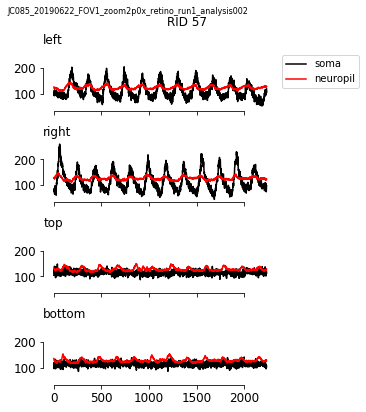

In [26]:
mag_thr=0.01 #if trace_type == 'neuropil' else 0.02
np_mag_thr = 0.1
pass_criterion='all'
plot_examples = True


print("Mag ratio: %.2f" % mag_thr)

#### Get FFT params
n_frames = scaninfo['stimulus']['n_frames']
frame_rate = scaninfo['stimulus']['frame_rate']
stim_freq_idx = scaninfo['stimulus']['stim_freq_idx']
freqs = np.fft.fftfreq(n_frames, float(1./frame_rate)) # Label frequency bins
sorted_freq_idxs = np.argsort(freqs)

#### Do FFT
fft_soma = dict((cond, ret_utils.do_fft_analysis(tdf, sorted_freq_idxs, stim_freq_idx)) for cond, tdf in soma_traces.items())
fft_np = dict((cond, ret_utils.do_fft_analysis(tdf, sorted_freq_idxs, stim_freq_idx)) for cond, tdf in np_traces.items())

# Get magratios -- each column is a condition
magratios_soma = pd.DataFrame(dict((cond, k[0]) for cond, k in fft_soma.items()))
magratios_np = pd.DataFrame(dict((cond, k[0]) for cond, k in fft_np.items()))

# Get phases
phases_soma = pd.DataFrame(dict((cond, k[1]) for cond, k in fft_soma.items()))
phases_np = pd.DataFrame(dict((cond, k[1]) for cond, k in fft_np.items()))

# Get average across conditions
mean_magratio_values_soma = magratios_soma.mean(axis=1).values 
mean_magratio_values_np = magratios_np.mean(axis=1).values


# Filter out bad cells
conds = [c for c in magratios_soma.columns if c!='blank']
if pass_criterion=='all':
    soma_rois = [i for i in magratios_soma.index if all(magratios_soma[conds].loc[i] >= mag_thr)]
    np_rois = [i for i in magratios_np.index if all(magratios_np[conds].loc[i] >= np_mag_thr)]
elif pass_criterion=='either':
    az_conds = [c for c in magratios_soma.columns if c in ['right', 'left']]
    el_conds = [c for c in magratios_soma.columns if c in ['top', 'bottom']]
    soma_rois = [i for i in magratios_soma.index \
                if (any(magratios_soma[az_conds].loc[i] >= mag_thr) \
                    and (any(magratios_soma[el_conds].loc[i] >= mag_thr))) ]
    np_rois = [i for i in magratios_np.index \
                if (any(magratios_np[az_conds].loc[i] >= mag_thr) \
                    and (any(magratios_np[el_conds].loc[i] >= np_mag_thr))) ]
elif pass_criterion == 'any':
    soma_rois = [i for i in magratios_soma.index if any(magratios_soma[conds].loc[i] >= mag_thr) ]
    np_rois = [i for i in magratios_np.index if any(magratios_np[conds].loc[i] >= np_mag_thr)]
else:
    soma_rois = magratios_soma.index.tolist()
    np_rois = magratios_np.index.tolist()

nrois_total = len(mean_magratio_values_soma)
print("[soma] %i out of %i cells pass mag-ratio thr (thr>=%.3f, %s)" % (len(soma_rois), nrois_total, mag_thr, pass_criterion))
print("[np] %i out of %i cells pass mag-ratio thr (thr>=%.3f, %s)" % (len(np_rois), nrois_total, np_mag_thr, pass_criterion))


# Use NP mean to get roi list
mag_thr = np_mag_thr if pass_criterion=='npmean' else mag_thr
roi_list = pass_np_rlist if pass_criterion=='npmean' else soma_rois
print("%i out of %i cells pass mag-ratio thr (thr>=%.3f, %s)" % (len(roi_list), nrois_total, mag_thr, pass_criterion))


# Sort ROIs by their average mag ratios
sorted_rois_soma = np.argsort(mean_magratio_values_soma)[::-1]
sorted_by_mag = [r for r in sorted_rois_soma if r in roi_list]

# Look at example cell
if plot_examples:
    ret_utils.plot_some_example_traces(soma_traces, np_traces, plot_rois=sorted_rois_soma[0:3],
                         dst_dir=curr_dst_dir, data_id=data_id)
    

In [27]:
pass_criterion

'all'

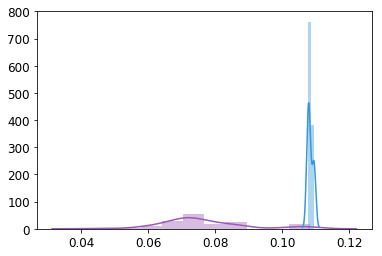

In [28]:
pl.figure()
sns.distplot(magratios_np.loc[soma_rois].mean(axis=1))
sns.distplot(magratios_np.loc[np_rois].mean(axis=1))

# Assign phase to neuropil

In [29]:
azim_phase_np, elev_phase_np, azim_np, elev_np = get_phase_masks(dilated_masks, phases_np, 
                                                            average_overlap=average_overlap, 
                                                            roi_list=None, use_cont=use_cont,
                                                            mask_thr=mask_thr, return_absolute=True)


NameError: name 'average_overlap' is not defined

In [412]:
# soma_mag_means = magratios_soma.mean(axis=1)
np_mag_means_from_soma = magratios_np.loc[soma_rois].mean(axis=1)
np_mag_means_from_np = magratios_np.loc[np_rois].mean(axis=1)

np_mag_means = magratios_np.mean(axis=1) # magratios_np.loc[np_rois].mean(axis=1)

In [413]:
np_mag_thr=0.1
pass_np_rlist_from_soma = np_mag_means_from_soma[np_mag_means_from_soma>=np_mag_thr].index.tolist()
pass_np_rlist_from_np = np_mag_means_from_np[np_mag_means_from_np>=np_mag_thr].index.tolist()
pass_np_rlist = np_mag_means[np_mag_means>=np_mag_thr].index.tolist()

print("NP filtered: %i, Soma filtered: %i, NP mean: %i" 
      % (len(pass_np_rlist_from_np), len(pass_np_rlist_from_soma), len(pass_np_rlist)))
fail_np_rlist_from_soma = [r for r in roi_list if r not in pass_np_rlist_from_soma]
fail_np_rlist = [r for r in roi_list if r not in pass_np_rlist]

NP filtered: 33, Soma filtered: 24, NP mean: 51


In [415]:
animalid, session

('JC099', '20190609')

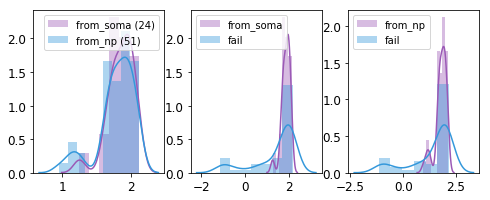

In [416]:
fig, axn = pl.subplots(1,3, figsize=(8,3))
ax = axn[0]
sns.distplot(azim_np[pass_np_rlist_from_soma].values, label='from_soma (%i)' % len(pass_np_rlist_from_soma), ax=ax)
sns.distplot(azim_np[pass_np_rlist].values, label='from_np (%i)' % len(pass_np_rlist), ax=ax)
ax.legend()

ax = axn[1]
sns.distplot(azim_np[pass_np_rlist_from_soma].values, label='from_soma', ax=ax)
sns.distplot(azim_np[fail_np_rlist_from_soma].values, label='fail', ax=ax)
ax.legend()


ax = axn[2]
sns.distplot(azim_np[pass_np_rlist].values, label='from_np', ax=ax)
sns.distplot(azim_np[fail_np_rlist].values, label='fail', ax=ax)
ax.legend()


In [417]:
import copy

In [418]:
print(len(pass_np_rlist))

51


In [420]:
roi_list = copy.copy(pass_np_rlist)
print(len(roi_list))

51


In [31]:
use_cont = True
average_overlap = True
filter_by_mag = True
mask_thr=0.01

# Set bounds for averaging
vmin = -np.pi if use_cont else 0
vmax = np.pi if use_cont else 2*np.pi

# Assign phase value to dilated masks
azim_phase_np, elev_phase_np = get_phase_masks(dilated_masks, phases_np, average_overlap=average_overlap, 
                                               roi_list=roi_list, use_cont=use_cont, mask_thr=mask_thr)

azim_phase_soma, elev_phase_soma = get_phase_masks(masks_soma, phases_soma, average_overlap=average_overlap, 
                                                   roi_list=roi_list, use_cont=use_cont, mask_thr=mask_thr)

# Mask images for plotting
azim_phase_mask_np = np.ma.masked_where(azim_phase_np==-100, azim_phase_np)
elev_phase_mask_np = np.ma.masked_where(elev_phase_np==-100, elev_phase_np)

azim_phase_mask_soma = np.ma.masked_where(azim_phase_soma==-100, azim_phase_soma)
elev_phase_mask_soma = np.ma.masked_where(elev_phase_soma==-100, elev_phase_soma)


# Smooth

In [32]:
# Spatial smooth neuropil dilated masks 
smooth_fwhm = 7 #21
azim_smoothed = ret_utils.smooth_neuropil(azim_phase_np, smooth_fwhm=smooth_fwhm)
elev_smoothed = ret_utils.smooth_neuropil(elev_phase_np, smooth_fwhm=smooth_fwhm)

if 'zoom1p0x' in fov:
    print("... resizing")
    azim_smoothed = cv2.resize(azim_smoothed, (new_d1, new_d2))
    elev_smoothed = cv2.resize(elev_smoothed, (new_d1, new_d2))
    
azim_smoothed = fill_and_smooth_nans(azim_smoothed)
elev_smoothed = fill_and_smooth_nans(elev_smoothed)

# Transform FOV to match widefield
azim_r = coreg.transform_2p_fov(azim_smoothed, pixel_size, normalize=False)
elev_r = coreg.transform_2p_fov(elev_smoothed, pixel_size, normalize=False)
print(azim_r[~np.isnan(azim_r)].min(), azim_r[~np.isnan(azim_r)].max())

az_fill = azim_r.copy()
el_fill = elev_r.copy()

azim_soma_r = coreg.transform_2p_fov(azim_phase_mask_np, pixel_size, normalize=False)
elev_soma_r = coreg.transform_2p_fov(elev_phase_mask_soma, pixel_size, normalize=False)

(0.0, 2.1406960421671575)


('/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1/retino_analsysis/retino-structure', 'soma-v-neuropil_dilate-center-10_spatial-smooth-7_circ_magthr-0.010-all')


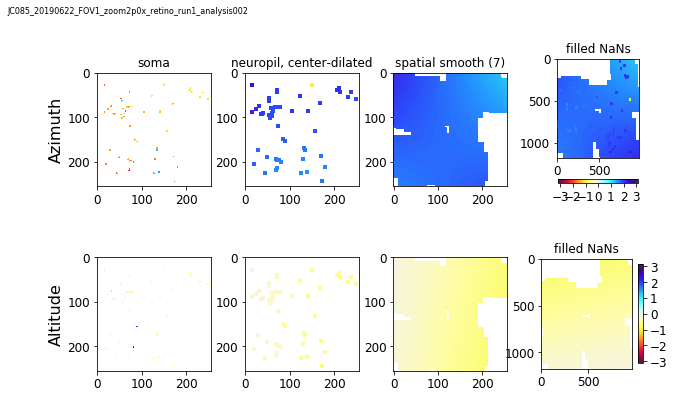

In [33]:
fig, axn = pl.subplots(2,4, figsize=(10,6))

ax = axn[0,0]
ax.imshow(azim_phase_mask_soma, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('soma')
ax.set_ylabel('Azimuth')

ax = axn[0, 1]
ax.set_title('neuropil, center-dilated')
ax.imshow(azim_phase_mask_np, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[0, 2]
ax.imshow(azim_smoothed, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('spatial smooth (%i)' % smooth_fwhm)

ax = axn[0, 3]
im0 = ax.imshow(az_fill, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('filled NaNs')
pl.colorbar(im0, ax=ax, orientation='horizontal', shrink=0.7)
ax.imshow(azim_soma_r, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1, 0]
ax.imshow(elev_phase_mask_soma, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_ylabel('Altitude')

ax = axn[1, 1]
ax.imshow(elev_phase_mask_np, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1, 2]
ax.imshow(elev_smoothed, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1, 3]
im1= ax.imshow(el_fill, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('filled NaNs')
pl.colorbar(im1, ax=ax, orientation='vertical', shrink=0.7)
ax.imshow(elev_soma_r, cmap=cmap_phase, vmin=vmin, vmax=vmax)

pl.subplots_adjust(wspace=0.3, hspace=0.3)
putils.label_figure(fig, data_id)

figname = 'soma-v-neuropil_dilate-center-%i_spatial-smooth-%i_circ_magthr-%.3f-%s' % (kernel_size, smooth_fwhm, mag_thr, pass_criterion)
#pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
print(curr_dst_dir, figname)

#### Plot smoothed azimuth neuropil

Text(0.5,1,u'Altitude')

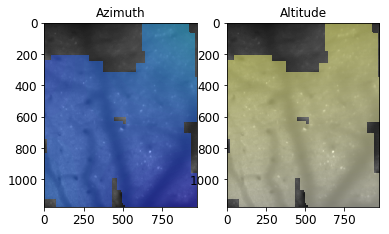

In [34]:
cmap = 'nipy_spectral' # cmap_phase
overlay = True
overlay_str = '_overlay' if overlay else ''
alpha = 0.5 if overlay else 1.0

fig, axn = pl.subplots(1,2)
ax = axn[0]
if overlay:
    ax.imshow(zimg_r, cmap='gray')
ax.imshow(azim_r, cmap=cmap_phase, vmin=vmin, vmax=vmax, alpha=alpha)
ax.set_title('Azimuth')

ax = axn[1]
if overlay:
    ax.imshow(zimg_r, cmap='gray')
ax.imshow(elev_r, cmap=cmap_phase, vmin=vmin, vmax=vmax, alpha=alpha)
ax.set_title('Altitude')

#figname = 'overlay_dilate-%i_spatial-fwhm-%i%s' % (kernel_size, smooth_fwhm, overlay_str)

#pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))


# Calculate image gradient

In [35]:
# Convert to degrees
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

In [36]:
plot_degrees = True

vmin=-np.pi
vmax=np.pi
img_az = convert_range(az_fill, oldmin=vmin, oldmax=vmax, newmin=screen_min, newmax=screen_max)
img_el = convert_range(el_fill, oldmin=vmin, oldmax=vmax,newmin=screen_min, newmax=screen_max)
vmin, vmax = (screen_min, screen_max)


In [37]:
# Calculate gradients
if plot_degrees:
    grad_az = calculate_gradients(img_az)
    grad_el = calculate_gradients(img_el)
    vmin, vmax = (screen_min, screen_max)
else:
    grad_az = calculate_gradients(az_fill)
    grad_el = calculate_gradients(el_fill)
    # vmin, vmax = (-np.pi, np.pi)
    
print(vmin, vmax)

(-59.7782, 59.7782)


('/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1/retino_analsysis/retino-structure', 'gradients_dilate-center-10_spatial-smooth-7_degrees_circ_magthr-0.010-all')


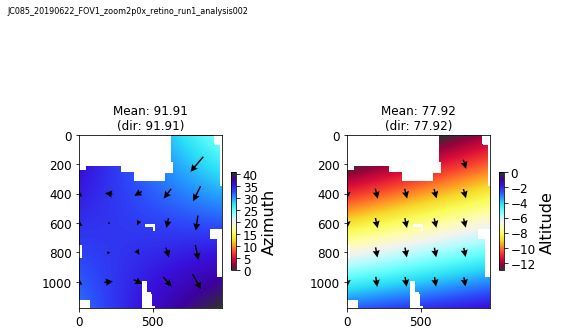

In [38]:
spacing = 200
scale = None #0.0001
width = 0.01 #0.01
headwidth=5

plot_str = 'degrees' if plot_degrees else ''
fig, axn = pl.subplots(1, 2, figsize=(8,6))
ax = axn[0]
im = ax.imshow(img_az, cmap=cmap_phase)#, vmin=vmin, vmax=vmax)
plot_gradients(grad_az, ax=ax, draw_interval=spacing, scale=scale, width=width,
              headwidth=headwidth)
fig.colorbar(im, ax=ax, shrink=0.3, label='Azimuth')

ax = axn[1]
im = ax.imshow(img_el,cmap=cmap_phase) #, vmin=vmin, vmax=vmax)
plot_gradients(grad_el, ax=ax, draw_interval=spacing, scale=scale, width=width,
              headwidth=headwidth)
fig.colorbar(im, ax=ax, shrink=0.3, label='Altitude')

pl.subplots_adjust(wspace=0.5, hspace=0.3)

putils.label_figure(fig, data_id)
figname = 'gradients_dilate-center-%i_spatial-smooth-%i_%s_circ_magthr-%.3f-%s' % (kernel_size, smooth_fwhm, plot_str, mag_thr, pass_criterion)

#pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [382]:
len(roi_list)

48

## Compute unit vector and project

In [41]:
avg_dir_el = np.rad2deg(grad_el['mean_direction'])
print('[EL]avg dir: %.2f deg' % avg_dir_el)
vhat_el = grad_el['vhat']

avg_dir_az = np.rad2deg(grad_az['mean_direction'])
print('[AZ]avg dir: %.2f deg' % avg_dir_az)
vhat_az = grad_az['vhat']

print(vhat_az, vhat_el)


[EL]avg dir: 77.92 deg
[AZ]avg dir: 91.91 deg
(array([-0.03332218,  0.99944466]), array([ 0.20931576,  0.9778481 ]))


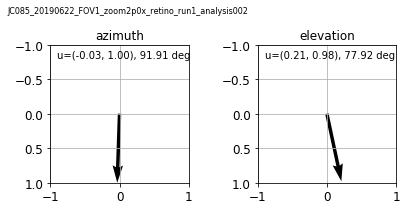

In [42]:
fig, axn = pl.subplots(1, 2, figsize=(6,3))

ax = axn[0]
ax.grid(True)
ax.set_title('azimuth')
vh = grad_az['vhat'].copy()
az_dir = np.rad2deg(np.arctan2(vh[1], vh[0])) #+ 360.) % 360
vhat_az = (np.cos(np.deg2rad(az_dir)), np.sin(np.deg2rad(az_dir)))

ax.text(-.9, -.8, "u=(%.2f, %.2f), %.2f deg" % (vhat_az[0], vhat_az[1], az_dir))
ax.quiver(0,0, vhat_az[0], vhat_az[1],  scale=1, scale_units='xy', 
          units='xy', angles='xy', width=.05, pivot='tail')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal')
ax.invert_yaxis()

ax = axn[1]
ax.grid(True)
ax.set_title('elevation')
el_dir = np.rad2deg(np.arctan2(vhat_el[1], vhat_el[0]))
ax.text(-0.9, -0.8, "u=(%.2f, %.2f), %.2f deg" % (vhat_el[0], vhat_el[1], el_dir))
ax.quiver(0,0, vhat_el[0], vhat_el[1],  scale=1, scale_units='xy', 
          units='xy', angles='xy', width=.05, pivot='tail')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal')
ax.invert_yaxis()

label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
#figname = 'gradients_unitvec_dilate-center-%i_spatial-smooth-%i_%s_magthr-%.3f-%s' % (kernel_size, smooth_fwhm, plot_str, mag_thr, pass_criterion)
#pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


# Project coordinates onto "prevailing" retino dir

In [385]:
gimg_az = grad_az['image'].copy()
gimg_el = grad_el['image'].copy()

d1, d2 = grad_az['image'].shape
print(d1, d2)
vhat_az = grad_az['vhat'].copy() #[0], -0.04) #abs(grad_az['vhat'][1]))
vhat_el = grad_el['vhat'].copy() #[0], -0.04) #abs(grad_az['vhat'][1]))
print(vhat_az, vhat_el)



(1177, 972)
(array([-0.99995744,  0.00922633]), array([ 0.8644171 ,  0.50277538]))


In [386]:
proj_az = np.array([np.dot(np.array((xv, yv)), vhat_az) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])
#proj_az2 = d2 - np.array([np.dot(np.array((xv, yv)), vhat_az) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])

ret_az = np.array([gimg_az[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )

proj_el = np.array([np.dot(np.array((xv, yv)), vhat_el) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])
ret_el = np.array([gimg_el[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )

pix = np.array([xv for yv in np.arange(0, d1) for xv in np.arange(0, d2) ])
coords = np.array([np.array((xv, yv)) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])


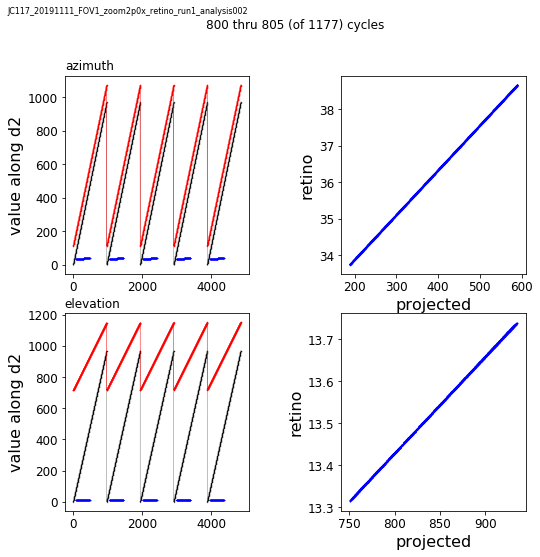

In [358]:
fig, axn = pl.subplots(2,2, figsize=(8,8)) #.figure()

ncyc=5

startcyc=800
endcyc=startcyc+ncyc

npts = d2*endcyc
spts = d2*startcyc
fig.suptitle("%i thru %i (of %i) cycles" % (startcyc, endcyc, d1))

ax = axn[0,0]
ax.set_title('azimuth', loc='left')
ax.plot(pix[spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)
ax.plot(proj_az[spts:npts], 'r',  marker='.', lw=0.5, markersize=0.5)
ax.plot(ret_az[spts:npts], 'b', marker='.', lw=0, markersize=0.5)
ax.set_ylabel('value along d2')

ax = axn[0,1]
offsets = [0 for i in np.arange(spts, npts)]
ax.scatter(proj_az[spts:npts], ret_az[spts:npts]+offsets, marker='.', s=2, c='b')
ax.set_xlabel('projected')
ax.set_ylabel('retino')


ax = axn[1,0]
ax.set_title('elevation', loc='left')
ax.plot(pix[spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)
ax.plot(proj_el[spts:npts], 'r',  marker='.', lw=0.5, markersize=0.5)
ax.plot(ret_el[spts:npts], 'b', marker='.', lw=0, markersize=0.5)

ax.set_ylabel('value along d2')
ax = axn[1,1]
offsets = [0 for i in np.arange(spts, npts)]
ax.scatter(proj_el[spts:npts], ret_el[spts:npts]+offsets, marker='.', s=2, c='b')
ax.set_xlabel('projected')
ax.set_ylabel('retino')


label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
#figname = 'test_projections__dilate-center-%i_spatial-smooth-%i_%s_magthr-%.3f-%s' % (kernel_size, smooth_fwhm, plot_str, mag_thr, pass_criterion)
#pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))


## Fit linear

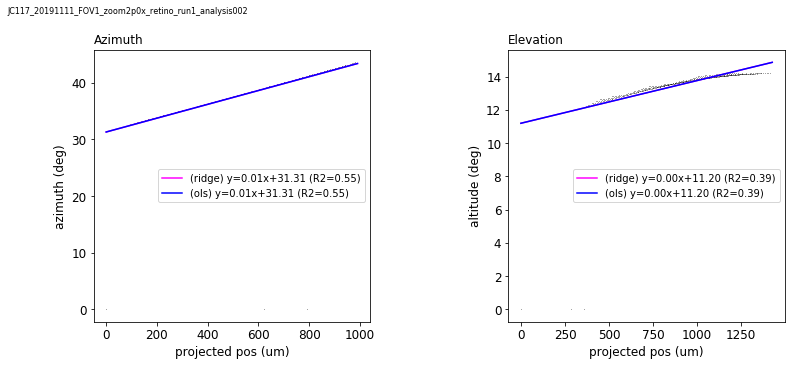

In [359]:
regr_model = 'ridge'
regr_line_color = 'magenta'
regr_model2 = 'ols' 

fitv_az, regr_az = evalrf.fit_linear_regr(proj_az[~np.isnan(ret_az)], ret_az[~np.isnan(ret_az)], 
                                          return_regr=True, model=regr_model)
fitv_el, regr_el = evalrf.fit_linear_regr(proj_el[~np.isnan(ret_el)], ret_el[~np.isnan(ret_el)], 
                                          return_regr=True, model=regr_model)

fitv_az2, regr_az2 = evalrf.fit_linear_regr(proj_az[~np.isnan(ret_az)], ret_az[~np.isnan(ret_az)], 
                                          return_regr=True, model=regr_model2)
fitv_el2, regr_el2 = evalrf.fit_linear_regr(proj_el[~np.isnan(ret_el)], ret_el[~np.isnan(ret_el)], 
                                          return_regr=True, model=regr_model2)

fig, axn = pl.subplots(1,2, figsize=(12, 5))
spacing=800
ax=axn[0]
ax.scatter(proj_az[0::spacing], ret_az[0::spacing], marker='.', lw=0, color='k', s=1)
r2_az = skmetrics.r2_score(ret_az[~np.isnan(ret_az)], fitv_az)
linfit_str = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model, float(regr_az.coef_), float(regr_az.intercept_), r2_az) 
ax.plot(proj_az[~np.isnan(ret_az)], fitv_az, color=regr_line_color, label=linfit_str)

r2_az2 = skmetrics.r2_score(ret_az[~np.isnan(ret_az)], fitv_az2)
linfit_str2 = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model2, float(regr_az2.coef_), float(regr_az2.intercept_), r2_az2) 
ax.plot(proj_az[~np.isnan(ret_az)], fitv_az2, color='b', label=linfit_str2)
ax.legend()

ax.set_title('Azimuth', loc='left')
ax.set_ylabel('azimuth (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

        
ax=axn[1]
#sns.regplot(proj_el, ret_el, ax=ax, scatter=False, color='k')
ax.scatter(proj_el[0::spacing], ret_el[0::spacing], marker='.', lw=0, color='k', s=1)
r2_el = skmetrics.r2_score(ret_el[~np.isnan(ret_el)], fitv_el)
linfit_str = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model, float(regr_el.coef_), float(regr_el.intercept_), r2_el) 
ax.plot(proj_el[~np.isnan(ret_el)], fitv_el, color=regr_line_color, label=linfit_str)

r2_el2 = skmetrics.r2_score(ret_el[~np.isnan(ret_el)], fitv_el2)
linfit_str2 = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model2, float(regr_el2.coef_), float(regr_el2.intercept_), r2_el2) 
ax.plot(proj_el[~np.isnan(ret_el)], fitv_el2, color='b', label=linfit_str2)
ax.legend()

ax.set_title('Elevation', loc='left')
ax.set_ylabel('altitude (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
#figname = 'Proj_versus_Retinopos__dilate-center-%i_spatial-smooth-%i_%s_magthr-%.3f-%s_test' % (kernel_size, smooth_fwhm, plot_str, mag_thr, pass_criterion)
#pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

# Compare RFs

In [ ]:
glob.glob(os.path.join(aggregate_dir, 'receptive-fields', 
                                     '%s__%s' % (traceid, rf_fit_desc), 'fits_and_coords*'))

In [ ]:
rf_fit_desc = 'fit-2dgaus_dff-no-cutoff'
rfpos_fpath = glob.glob(os.path.join(aggregate_dir, 'receptive-fields', 
                                     '%s__%s' % (traceid, rf_fit_desc), 'fits_and_coords*'))[1]
print(rfpos_fpath)

with open(rfpos_fpath, 'rb') as f:
    rfpos = pkl.load(f)
    rfpos=rfpos['df']
rfpos.keys()



In [ ]:
fovnum=1
datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
curr_rfs = rfpos[rfpos['datakey']==datakey].copy()
print(datakey, curr_rfs.shape)


In [ ]:
rfdf = curr_rfs.copy()
rfdf['ml_proj']=''
rfdf['ap_proj']=''
#retinorun = projdf[projdf['datakey']==datakey].groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
#p_df = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)]
#fpath = p_df['fpath'].unique()[0]
#gpath = os.path.join(os.path.split(fpath)[0], 'vectors_%s.pkl' % magthr_str)
#with open(gpath, 'rb') as f:
#    gresults = pkl.load(f)

# Project FOV coordinates
rfdf['ml_proj'][rfdf.index] = np.array([np.dot(np.array((ml, ap)), vhat_az) \
                                      for ap, ml in curr_rfs[['ap_pos', 'ml_pos']].values])
rfdf['ap_proj'][rfdf.index] = np.array([np.dot(np.array((ml, ap)), vhat_el) \
                                      for ap, ml in curr_rfs[['ap_pos', 'ml_pos']].values])

## Plot

In [ ]:
r2_thr=0.5
#rfname = 'rfs10'

fig, axn = pl.subplots(2,2, figsize=(8,8))
for ri, (rfname, expdf) in enumerate(rfdf.groupby(['experiment'])):
    for ci, cond in enumerate(['az', 'el']):
        ax = axn[ci, ri]
        xname = 'ml' if cond=='az' else 'ap'
        yname = 'x0' if cond=='az' else 'y0'

        # Plot RF positions vs. cell locs
        cell_locs = expdf['%s_pos' % xname].values
        rf_locs = expdf[yname].values
        ax.scatter(cell_locs, rf_locs, marker='o', s=5, color='k', label='original')

        proj_locs = expdf['%s_proj' % xname].values
        ax.scatter(proj_locs, rf_locs, marker='o', s=5, color='orange', label='projected')

        #proj_locs2 = abs(np.array([np.dot(np.array((ml, ap)), gresults[cond]['vhat']) \
        #                         for ap, ml in edf[['ap_pos', 'ml_pos']].values]))

        # plot gradient line
        ret_ = ret_az if cond=='az' else ret_el
        fitv_ = fitv_az if cond=='az' else fitv_el
        regr_ = regr_az if cond=='az' else regr_el 
        slope = float(regr_.coef_)
        intercept = float(regr_.intercept_)
        r2_val = skmetrics.r2_score(ret_[~np.isnan(ret_)], fitv_)
        linfit_str = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model, slope, intercept, r2_val) 

        ls = ':' if r2_val < r2_thr else '-'
        label_prefix = 'R2=%.2f' % r2_val
        label = True
        ax = abline(slope, intercept, ax=ax, color='k',
                    label=label, label_prefix=label_prefix, ls=ls)
        ax.set_title('%s (%s)' % (rfname, cond), loc='left', fontsize=20)

        ax.legend(bbox_to_anchor=(0.7, 1), loc='top')

pl.subplots_adjust(top=0.7, wspace=0.5, hspace=0.5)